<a href="https://colab.research.google.com/github/yaeeun916/RP-Lab-DL-School-HW/blob/main/brain_tumor_classification(vgg16).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from skimage import io, transform
import torchvision
from torchvision import models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt 
import zipfile
import time
import os

# 경고 메시지 무시하기
import warnings
warnings.filterwarnings("ignore")

# 반응형 모드 설정 (바로 그래프가 업데이트 된다)
plt.ion() 

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'

# 재생산성(재실행해도 같은 결과가 나오도록)을 위해 랜덤 시드를 준다
torch.manual_seed(777)
if device=='cuda':
  torch.cuda.manual_seed_all(777)

print(device)

cuda


# Dataset

https://tutorials.pytorch.kr/recipes/recipes/custom_dataset_transforms_loader.html

## 데이터 다운받아 ./data/brain_tumor/ 경로에 위치시키기

참고: 다운받은 뇌종양 데이터셋의 구조

Brain-Tumor-Classification-DataSet-master 폴더 내에 Testing, Training 폴더 내에 glioma_tumor, meningioma_tumor, no_tumor, pituitary_tumor 폴더

glioma_tumor, meningioma_tumor, no_tumor, pituitary_tumor 폴더 내에 이미지 (파일 이름: image(인덱스).jpg)

In [ ]:
!wget https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet/archive/master.zip
os.makedirs("./data/brain_tumor/", exist_ok=True) #exist_ok=True: 해당 디렉토리가 기존에 존재하면 넘어가고, 없을 경우에만 생성
if not os.path.exists("./data/brain_tumor/master.zip"): #동일 경로에 다운받은적 없다면
  with zipfile.ZipFile("master.zip","r") as zip_ref:
    zip_ref.extractall("./data/brain_tumor/") #./data/brain_tumor/에 압축 해제

--2021-03-03 05:03:49--  https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet/archive/master.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet/zip/master [following]
--2021-03-03 05:03:50--  https://codeload.github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.121.9
Connecting to codeload.github.com (codeload.github.com)|140.82.121.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [               <=>  ]  86.97M  26.4MB/s    in 3.5s    

2021-03-03 05:03:53 (24.7 MB/s) - ‘master.zip’ saved [91198591]



## class로 custom dataset 만들기
기본 구성:

def init(self, x, transform)

def len(self)

def getitem(self,index)

In [ ]:
class BrainTumorDataset(Dataset): #class Dataset을 상속한 class BrainTumorDataset
  train_list=["Brain-Tumor-Classification-DataSet-master/Training/no_tumor",
              "Brain-Tumor-Classification-DataSet-master/Training/glioma_tumor",
              "Brain-Tumor-Classification-DataSet-master/Training/meningioma_tumor",
              "Brain-Tumor-Classification-DataSet-master/Training/pituitary_tumor"]
  test_list=["Brain-Tumor-Classification-DataSet-master/Testing/no_tumor",
             "Brain-Tumor-Classification-DataSet-master/Testing/glioma_tumor",
              "Brain-Tumor-Classification-DataSet-master/Testing/meningioma_tumor",
              "Brain-Tumor-Classification-DataSet-master/Testing/pituitary_tumor"]

  def __init__(self, root_dir="./data/brain_tumor/", train=True, transform=None):
      #매개변수 :
      #    root_dir (문자열): 모든 이미지가 있는 폴더 경로 
      #    train: True면 train set, False면 test set
      #    transform (호출가능한 함수, 선택적 매개변수): 샘플에 적용 될 수 있는 선택적 변환
      #    __init__에선 이미지를 읽지 않고 __getitem__에서 읽는다 (메모리)
      self.root_dir = root_dir
      self.train = train  
      self.transform = transform

      if self.train:
        self.train_data=[] # 이미지 파일의 경로를 append할 list
        self.train_label=[] # label(0~3)을 append할 list
        for tr in BrainTumorDataset.train_list: 
          folder=os.path.join(self.root_dir, tr) #glioma_tumor, meningioma_tumor, no_tumor, pituitary_tumor 폴더의 경로
          for currentdir, dirs, files in os.walk(folder): 
            for file in files: #files: folder 내 모든 파일
              image_name=os.path.join(folder, file) #image_name=이미지 파일의 경로
              self.train_data.append(image_name)
              self.train_label.append(BrainTumorDataset.train_list.index(tr)) 
              # torch.nn.CrossEntropyLoss expects a class index (0 to C-1) as the target 
              #  :no_tumor는 0, glioma_tumor는 1, meningioma_tumor는 2, pituitary_tumor는 3으로 train_label에 append
              # one hot encoding은 torch.nn.CrossEntropyLoss가 해줌
      else:
        self.test_data=[]
        self.test_label=[]
        for ts in BrainTumorDataset.test_list:
          folder=os.path.join(self.root_dir, ts)
          for currentdir, dirs, files in os.walk(folder):
            for file in files:
              image_name=os.path.join(folder, file)
              self.test_data.append(image_name)
              self.test_label.append(BrainTumorDataset.test_list.index(ts))


  def __len__(self):
      if self.train:
        return len(self.train_data)
      else:
        return len(self.test_data)

  def __getitem__(self, idx):
      if torch.is_tensor(idx):
          idx = idx.tolist()
      
      if self.train:
        img, target=io.imread(self.train_data[idx]), self.train_label[idx]
      else:
        img, target=io.imread(self.test_data[idx]), self.test_label[idx]
      # skimage : represent image as numpy array, provides easy-to-use functions for reading, displaying, and saving images
      # skimage.io.imread : reads the image, converts it from JPEG into a NumPy array, and returns the array (numpy image: H x W x C)

      if self.transform:
        img=self.transform(img)

      return img, target
      # img는 numpy array, target은 int

## 데이터 전처리
위에서 볼 수 있었던 한가지 문제점은 샘플들이 다 같은 사이즈가 아니라는 것. 대부분의 신경망(neural networks)은 고정된 크기의 이미지라고 가정하므로 신경망에 주기 전에 처리할 과정을 작성해야 한다.
All transformations accept PIL Image, Tensor Image

*   transforms.ToPILImage(): Convert a tensor or an ndarray to PIL Image. 만든 데이터셋은 numpy array를 append하는데 transformation은 PIL 또는 tensor를 받기 때문에. ToTensor()먼저 안 하는 이유는 range가 [0.0, 1.0]으로 바껴서
*   transforms.Resize(size): 이미지 크기 변경, image can be a PIL Image or a torch Tensor 
*   transforms.ColorJitter(): Randomly change the brightness, contrast and saturation of an image. data augmentation 중 제일 뇌 영상에 적합하다고 생각해서 선정. 방향이 정확히 맞춰서 들어온다고 가정할 수 있으니 굳이 플립, 로테이션은 하지 않기로.
*   transforms.ToTensor(): Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
PyTorch는 tensor를 사용하므로 numpy 이미지들을 Torch.tensor 이미지로 변환
*    transforms.Normalize(mean, std): normalize

모든 pretrained model을 쓸 때 이미지 데이터는 [3, H, W] 형식이어야 하고, H,W는 224 이상이어야 한다. 또 아래 코드처럼 정규화된 이미지 데이터로 학습된 것이기 때문에, 이 모델들을 사용할 때에는 데이터셋을 이와 같이 정규화시켜주어야 한다.

transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])

In [ ]:
transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize((224, 224)),
                                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ]) 


In [ ]:
trainset=BrainTumorDataset(root_dir='./data/brain_tumor/',
                              train=True,
                              transform=transform)

#split train set into train set & validation set
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size], generator=torch.Generator().manual_seed(777))

testset=brain_train=BrainTumorDataset(root_dir='./data/brain_tumor/',
                              train=False,
                              transform=transform)

# Dataloader 


In [ ]:
batchsize = 30

trainloader = DataLoader(dataset=trainset, 
                        batch_size=batchsize,
                        shuffle=True,
                        drop_last=True)

valloader = DataLoader(dataset=valset, 
                        batch_size=batchsize,
                        shuffle=True,
                        drop_last=True)

testloader = DataLoader(dataset=testset, 
                         batch_size=1, 
                         shuffle=False, #test는 셔플할 필요 없음
                         drop_last=True)

# 모델 만들기



## pretrained VGG16


In [ ]:
net = models.vgg16_bn(pretrained=True)#vgg16 with batch normalization
for param in net.parameters():
    param.requires_grad = True        #fine-tune entire network
net.classifier[6].out_features = 4    #net의 마지막 레이어 교체 (brain tumor classification의 class 수는 4)
net.to(device)

#구조 확인
print(net)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 25

# 학습

https://www.kaggle.com/carloalbertobarbano/vgg16-transfer-learning-pytorch

https://greeksharifa.github.io/pytorch/2018/11/10/pytorch-usage-03-How-to-Use-PyTorch/

## 학습시키기

transfer learning
- 학습할 dataset이 original dataset과 very similar/very different한지, very little data/quite a lot of data인지에 따라 layer를 얼만큼 freeze하고 얼만큼 train할지 결정
- brain tumor dataset은 different from original dataset(ImageNet) & large : fine-tune entire network
- lr: 1/10of original lr에서 시작

https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html
https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/


스케줄러마다 적용시 사용 방식이 다름:
http://www.gisdeveloper.co.kr/?p=8443

In [ ]:
def train_model(model, criterion, optimizer, lr_sche, num_epochs, PATH):
  since = time.time()

  #best accuracy
  best_acc = 0.0 

  train_cost_list=[]
  train_acc_list=[]
  val_cost_list=[]
  val_acc_list=[]

  for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)

      #train phase
      lr_sche.step() # 만약 lr_scheduler.ReduceLROnPlateau쓸거면 optimizer.step() 다음에 와야함(링크 참고)
      model.train()  # Set model to training mode
              
      cost_train = 0.0  
      corrects_train = 0 

      for X, Y in trainloader: #for each batch
          X=X.float().to(device)
          Y=Y.to(device)

          optimizer.zero_grad()
          hypothesis=model(X)
          preds=torch.argmax(hypothesis, 1)
          cost=criterion(hypothesis, Y)

          # backward + optimize only if in training phase (validation set으로는 학습하지 않는다)
          cost.backward()
          optimizer.step()

          cost_train += cost.item() # 한 epoch 내 모든 batch의 cost 누적(+=cost하면 history도 저장됨. +=cost.item()해야 numerical data만 저장)
          corrects_train += torch.sum(preds == Y).item() # 한 epoch 내 모든 batch의 맞춘 갯수 누적

      epoch_cost = cost_train / len(trainloader)
      epoch_acc = corrects_train / (X.size(0)*len(trainloader))
        # drop_last=True로 했기 때문에 이렇게 계산
        #     : 항상 batch의 데이터 수(=X.size(0)) = 설정한 batch size
        #     : 1 epoch에서 사용된 데이터 수 = X.size(0)*total_batch != len(trainset). trainset의 모든 데이터 사용X

        # drop_last=False라면 trainset의 모든 데이터가 사용되고, 마지막 batch의 데이터 수는 설정한 batch size보다 작음
        #     : cost_train += cost * X.size(0)           => cost는 1batch내 모든 데이터의 cost의 평균이니 다시 X.size(0) 곱해주고
        #     : epoch_cost = cost_train / len(trainset)  => 사용된 데이터 수로 나눠줌

      print('Train Cost: {:.4f} Acc: {:.4f}'.format(epoch_cost, epoch_acc))
      train_cost_list.append(epoch_cost)
      train_acc_list.append(epoch_acc)


      #validation phase : 5 epoch마다
      if epoch%5==4:
        with torch.no_grad():# 학습 안 할 것이니 computation 저장X, frees GPU spaces
          model.eval()  # Set model to evaluate mode : batchnorm은 학습에서 저장된 파라미터 사용,  dropout은 비활성화

          cost_val = 0.0
          corrects_val = 0

          for X, Y in valloader:
              X=X.float().to(device)
              Y=Y.to(device)

              optimizer.zero_grad()
              hypothesis=model(X)
              preds = torch.argmax(hypothesis, 1)
              cost = criterion(hypothesis, Y)

              cost_val += cost.item() 
              corrects_val += torch.sum(preds == Y).item()

          epoch_cost_val = cost_val / len(valloader)
          epoch_acc_val = corrects_val / (X.size(0)*len(valloader))

          print('Validation Cost: {:.4f} Acc: {:.4f}'.format(epoch_cost_val, epoch_acc_val))
          val_cost_list.append(epoch_cost_val)
          val_acc_list.append(epoch_acc_val)

          # validation set에서 accuracy 가장 높았던 hyperparameter를 선택, 저장
          if epoch_acc_val > best_acc:
            best_acc = epoch_acc_val
            torch.save(model.state_dict(), PATH)

      print()


  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))


  # Loss Tracker, Accuracy Tracker 그래프 그리기
  plt.subplot(2,1,1)
  plt.plot(train_cost_list, 'r', label='train cost') #plot(y): plot y using x as index array 0..N-1
  plt.plot([5*x+4 for x in range(num_epochs//5)], val_cost_list, 'b', label='val cost') #plot(x, y)    
  plt.xlabel('epoch')
  plt.ylabel('cost')
  plt.title('Loss Tracker')
  plt.legend(loc='upper right')
  plt.show()

  plt.subplot(2,2,2)
  plt.plot(train_acc_list, 'r', label='train acc')
  plt.plot([5*x+4 for x in range(num_epochs//5)], val_acc_list, 'b', label='val acc')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy Tracker')
  plt.legend(loc='upper right')
  plt.show()



In [ ]:
criterion=nn.CrossEntropyLoss() 
optimizer=torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
lr_sche=torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
#lr_sche=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, threshold=0.0001)
num_epochs=5
PATH = './braintumor_model.pth'

Epoch 0/4
----------
Train Cost: 1.1228 Acc: 0.7316

Epoch 1/4
----------
Train Cost: 0.1669 Acc: 0.9417

Epoch 2/4
----------
Train Cost: 0.0703 Acc: 0.9772

Epoch 3/4
----------
Train Cost: 0.0323 Acc: 0.9908

Epoch 4/4
----------
Train Cost: 0.0214 Acc: 0.9934
Validation Cost: 0.2002 Acc: 0.9281

Training complete in 3m 40s
Best val Acc: 0.928070


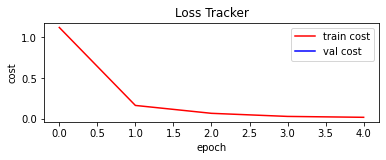

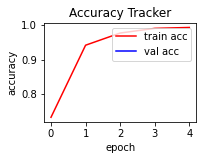

In [ ]:
train_model(net, criterion, optimizer, lr_sche, num_epochs, PATH)

# 5. 테스트

## 5.1 저장한 hyperparameter 불러오기
- GPU에서 저장하고 GPU에서 불러오기

https://tutorials.pytorch.kr/beginner/saving_loading_models.html

In [ ]:
net.load_state_dict(torch.load(PATH))
net.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

## 5.2 테스트하기

In [ ]:
with torch.no_grad(): #학습을 진행하지 않을 것이므로 torch.no_grad()
    net.eval() #model에 batch normalization 있으면 train mode, eval mode 구별 필요
    correct_predictions=0
    for X, Y in testloader: #batch_size=1
        X=X.float().to(device)
        Y=Y.to(device)

        prediction=net(X)
        correct_prediction=torch.argmax(prediction, 1)==Y #boolean tensor(True, False)
        correct_predictions+=correct_prediction.float().item() #boolean tensor에서 float tensor에서 scalar로
    accuracy=correct_predictions/len(testloader) #batch size 1로 했으니 len(testset)=len(testloader)
    print('Test Acc:', accuracy)

Test Acc: 0.766497461928934
